This notebook uses a current PR of gcr-catalogs, make sure you clone the PR and add it to `sys.path`
```
git clone -b coadd_reader git@github.com:djperrefort/gcr-catalogs.git
```

This notebook also requires `FoFCatalogMatching`: https://github.com/yymao/FoFCatalogMatching

In [1]:
import sys
sys.path.insert(0, '/global/common/software/lsst/common/miniconda/current/lib/python3.6/site-packages')
sys.path.insert(0, '/path/to/your/cloned/gcr-catalogs')

from collections import defaultdict
import numpy as np
from astropy.coordinates import SkyCoord
import FoFCatalogMatching
from GCR import GCRQuery
import GCRCatalogs

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
coaddCat = GCRCatalogs.load_catalog('dc2_coadd_run1.1p_tract4850')

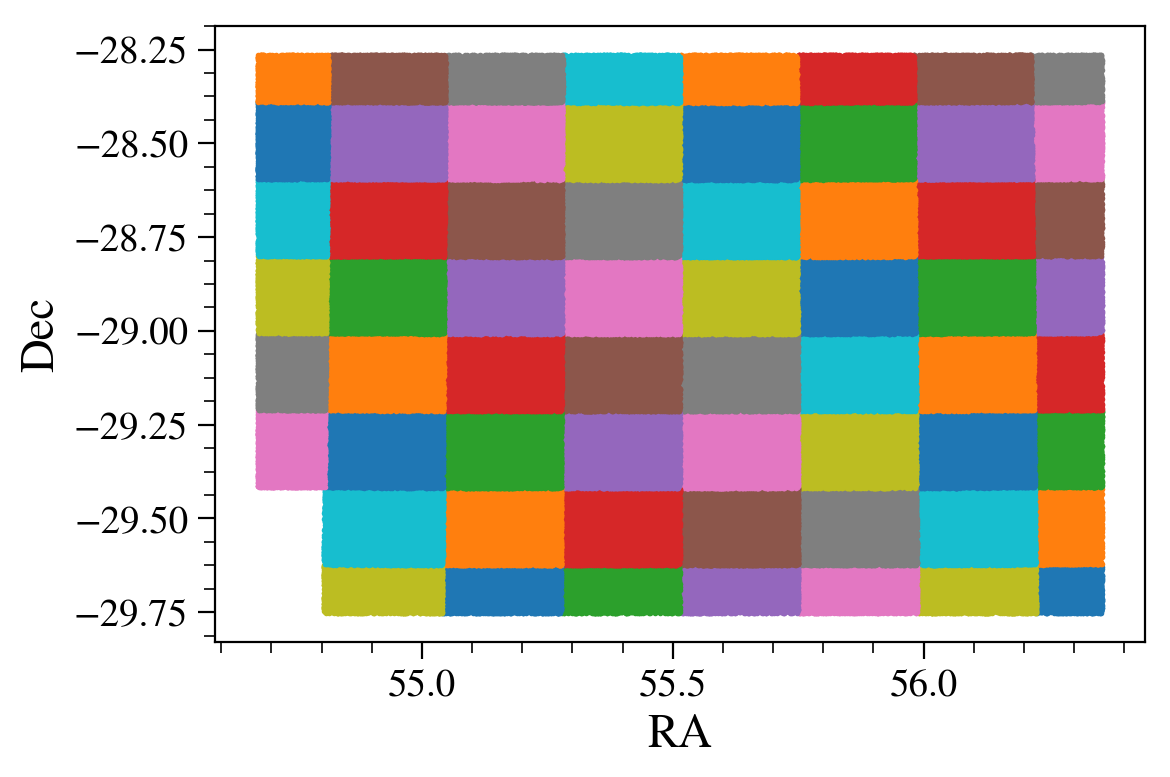

In [4]:
for data in coaddCat.get_quantities(['ra', 'dec'], return_iterator=True):
    plt.scatter(data['ra'], data['dec'], s=1, rasterized=True);

plt.xlabel('RA');
plt.ylabel('Dec');

In [5]:
# do matching on a small area
ra_min, ra_max = 55.5, 56.0
dec_min, dec_max = -29.0, -28.5

coord_filter = GCRQuery(
    'ra >= {}'.format(ra_min),
    'ra < {}'.format(ra_max),
    'dec >= {}'.format(dec_min),
    'dec < {}'.format(dec_max),
)

In [6]:
mag_cut = GCRQuery(
    (np.isfinite, 'i_magLSST'),
    'i_magLSST < 24.5',
)

In [7]:
coordinatesCoaddCat = coaddCat.get_quantities(['ra', 'dec'], filters=[coord_filter, mag_cut])

In [8]:
refCat = GCRCatalogs.load_catalog('dc2_reference_run1.1p')
refCat.add_quantity_modifier('i_magLSST', 'lsst_i')

In [9]:
coordinatesRefCat = refCat.get_quantities(['ra','dec'], filters=[coord_filter, mag_cut])

../../gcr-catalogs/GCRCatalogs/reference_catalog.py:59: UserWarning: genfromtxt: Empty input file: "<_io.BufferedReader name='/global/projecta/projectdirs/lsst/groups/SSim/DC2/reference_catalogs/dc2_reference_catalog_dc2v2.1.2.txt'>"
  data = np.genfromtxt(f, self._data_dtype, delimiter=',', max_rows=self._nlines)


In [10]:
results = FoFCatalogMatching.match(
    catalog_dict=dict(ref=coordinatesRefCat, coadd=coordinatesCoaddCat),
    linking_lengths=1.0,
    catalog_len_getter=lambda x: len(x['ra']),
)

In [11]:
n_max = 5
hist2d = np.zeros((n_max, n_max))
ref_idx = defaultdict(list)
coadd_idx = defaultdict(list)

for group in results.groups:
    ref_mask = group['catalog_key'] == 'ref'
    coadd_mask = group['catalog_key'] == 'coadd'
    
    n_ref = np.count_nonzero(ref_mask)
    n_coadd = np.count_nonzero(coadd_mask)
    if n_ref < n_max and n_coadd < n_max:
        hist2d[n_ref, n_coadd] += 1
    
    key = (n_ref, n_coadd)
    ref_idx[key].append(group['row_index'][ref_mask].data)
    coadd_idx[key].append(group['row_index'][coadd_mask].data)

for key in ref_idx:
    ref_idx[key] = np.concatenate(ref_idx[key])
    coadd_idx[key] = np.concatenate(coadd_idx[key])

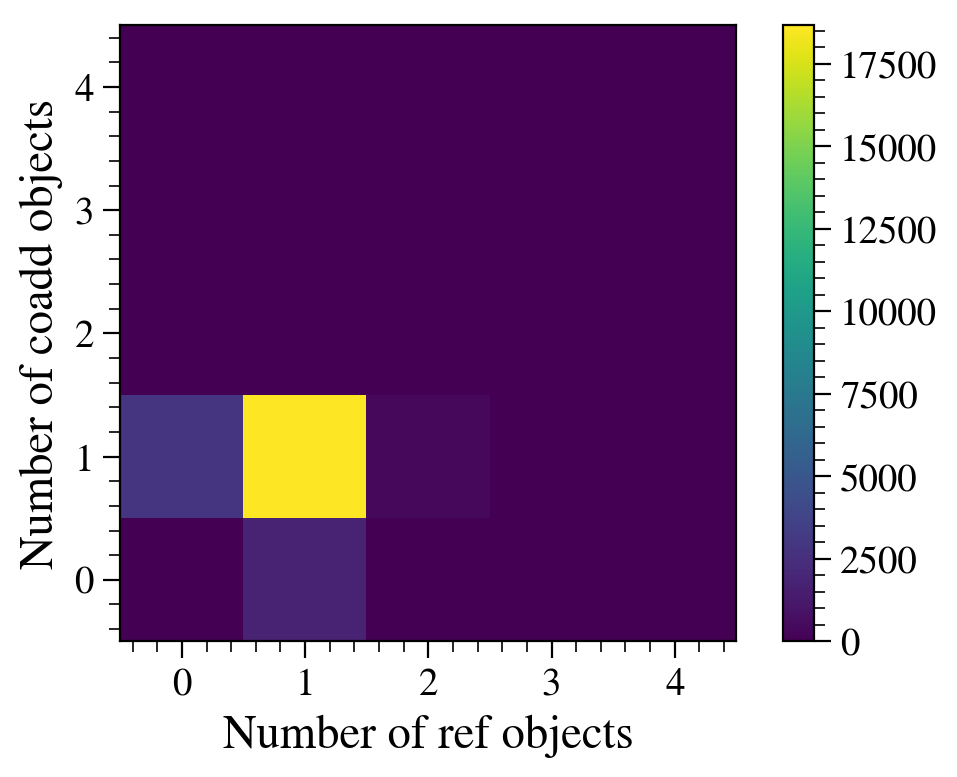

In [13]:
plt.imshow(hist2d.T, extent=(-0.5, n_max-0.5, -0.5, n_max-0.5), origin='lower');
plt.xlabel('Number of ref objects');
plt.ylabel('Number of coadd objects');
plt.colorbar();

In [14]:
delta_ra = coordinatesCoaddCat['ra'][coadd_idx[(1,1)]] - coordinatesRefCat['ra'][ref_idx[(1,1)]]
delta_dec = coordinatesCoaddCat['dec'][coadd_idx[(1,1)]] - coordinatesRefCat['dec'][ref_idx[(1,1)]]

ref_sc = SkyCoord(coordinatesRefCat['ra'][ref_idx[(1,1)]], coordinatesRefCat['dec'][ref_idx[(1,1)]], unit="deg")
coadd_sc = SkyCoord(coordinatesCoaddCat['ra'][coadd_idx[(1,1)]], coordinatesCoaddCat['dec'][coadd_idx[(1,1)]], unit="deg")
delta_arcsec = ref_sc.separation(coadd_sc).arcsec

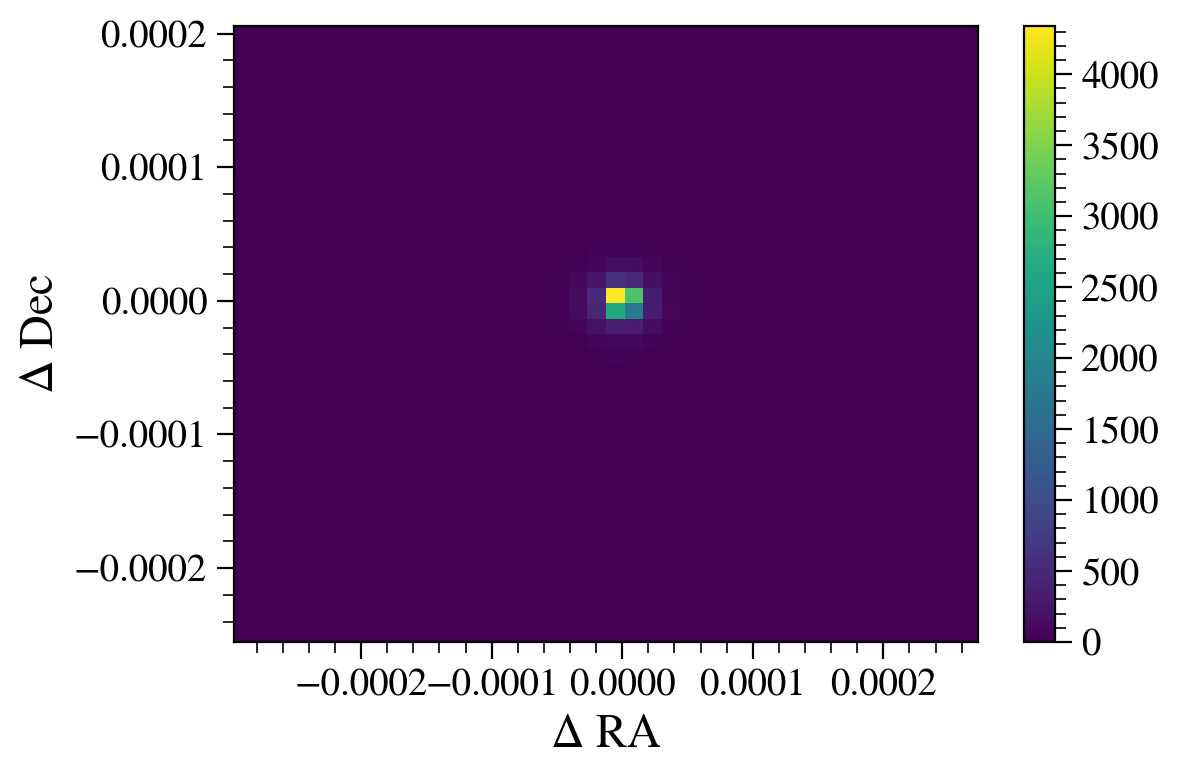

In [15]:
plt.hist2d(delta_ra, delta_dec, bins=40);
plt.xlabel(r'$\Delta$ RA');
plt.ylabel(r'$\Delta$ Dec');
plt.colorbar();

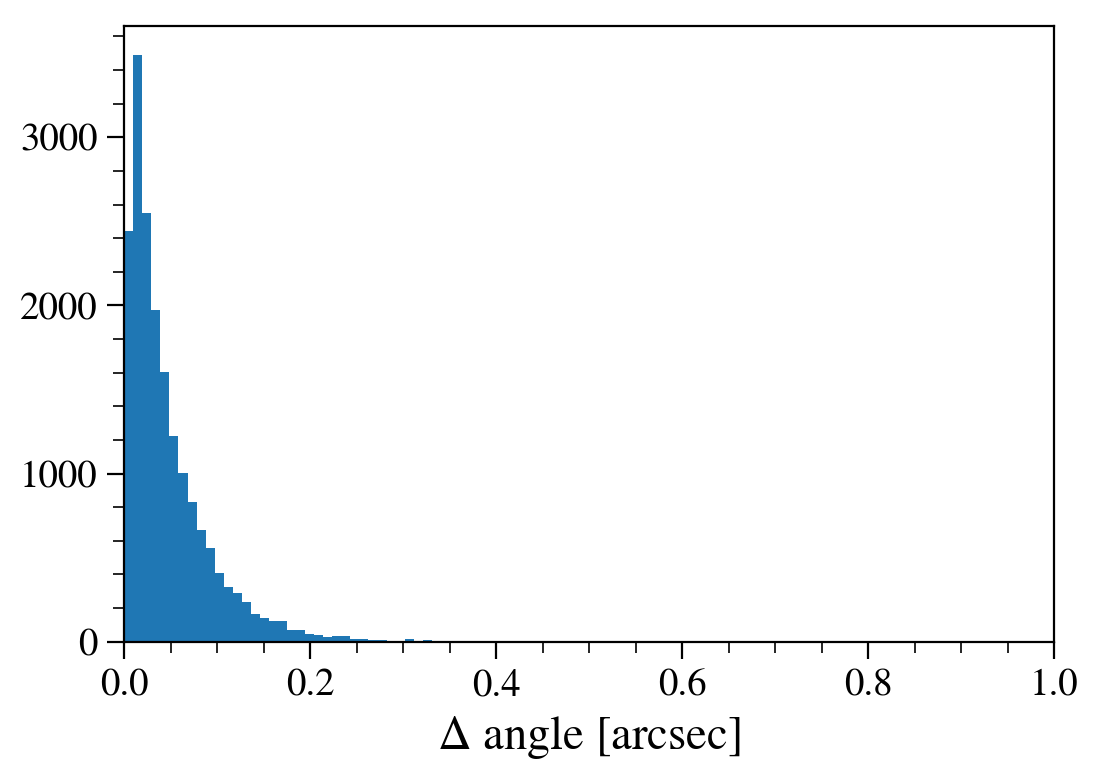

In [16]:
#Plotting Delta angle for the outputs
plt.hist(delta_arcsec, bins=100);
plt.xlim(0, 1.0);
plt.xlabel(r'$\Delta$ angle [arcsec]');